In [51]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
import torchaudio
from torchaudio import transforms as audioTFs
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

from pandas import read_csv
import matplotlib.pyplot as plt
from librosa import power_to_db

In [52]:
torch.cuda.is_available()

True

# Audio Classification with a CSNN



#### Installing a sound backend

If you haven't worked with audio files before on your system, you're going to want to install a sound backend package. 

For windows users, install soundfile with `pip install soundfile`.

For linux based users (Linux, Ubuntu, Mac OS), install the sox package with `pip install sox`. 

In [53]:
# define a dataset superclass for this particular dataset
class AudioMNISTDataset(Dataset):
    def __init__(self, annotations_file, audio_dir) -> None:
        self.annotations = read_csv(annotations_file)
        self.audio_dir = audio_dir
        
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_file_path = self.getAudioPath(index=index)
        label = str(self.annotations.loc[index, 'classification'])
        waveform, _ = torchaudio.load(audio_file_path)

        return waveform, label
    
    def getAudioPath(self, index):
        audio_file_name = self.annotations.loc[index, 'filename']
        speaker = str(self.annotations.loc[index, 'speaker'])
        if len(speaker) != 2:
            speaker = '0' + speaker

        audio_file_path = f'{self.audio_dir}/{speaker}/{audio_file_name}'
        return audio_file_path
    

# initialize the dataset
annotations_file_path = './data/audio-mnist/audioMNIST_annotations.csv'
audio_dir_path = './data/audio-mnist'

audio_dataset = AudioMNISTDataset(annotations_file=annotations_file_path, audio_dir=audio_dir_path)

There's a small problem though: our audio files are of differing lengths, most are nearly 1 second long (48000 samples at a 48000/s sample rate) but none are over the length (see below cell). 

We want to make sure each sample is of equal length to avoid the model spontaneously combusting because data entries aren't uniform in length. To do this without removing any existing features is to pad every file with some zeros.

For how much? I'm arbitrarily picking 48000 samples as that makes a file of exactly 1 second long while only being 2 samples longer than the largest sample size (see below cell).

In [54]:
# # verify the range of lengths for our audio files
# min = torch.inf
# max = 0
# for i in range(30000):
#     tLen = len(data[i][0][0])
#     if tLen < min:
#         min = tLen
#     if tLen > max:
#         max = tLen
#     print(i, '/ 30000 samples checked', end='\r')

# print('min:', min, 'max:', max)

So we want to pad each audio to 48000 samples, how do we do that to the dataset?

If we look up to the cell defining AudioMNISTDataset, we'll see some commented out lines. Since this dataset class generates the tensors dynamically as indexed, the transformation would also occur dynamically. To change this dataset, let's redefine the indexing magic method (`__getitem__`) to a redesigned version including the first transformation.

In [55]:
def padAudio(waveform: torch.TensorType, cutoff):
    """Pad a column waveform (torch.Tensor([[x1, x2, ... xn]])) with 0s
    until a given thresholdor snip excess past the threshold"""
    wf = waveform.flatten()
    curLen = len(wf)
    if curLen == cutoff:
        return waveform
    if curLen < cutoff:
        wf = torch.cat((wf, torch.zeros(cutoff-curLen)))
    else:
        wf = wf[:cutoff]
    return wf.unsqueeze(dim=0)

def getPaddedAudio(self, index):
    audio_file_path = self.getAudioPath(index=index)
    label = str(self.annotations.loc[index, 'classification'])
    waveform, _ = torchaudio.load(audio_file_path)

    waveform = padAudio(waveform, cutoff=48000)

    return waveform, label

# get audio vector length with old __getitem__ method
print('First Audio Vector Length:', len(audio_dataset[0][0][0]))

AudioMNISTDataset.__getitem__ = getPaddedAudio
audio_dataset = AudioMNISTDataset(annotations_file=annotations_file_path, audio_dir=audio_dir_path)

# get audio vector length with new __getitem__ method
print('First Audio Vector Length (Post-padding):', len(audio_dataset[0][0][0]))

First Audio Vector Length: 35877
First Audio Vector Length (Post-padding): 48000


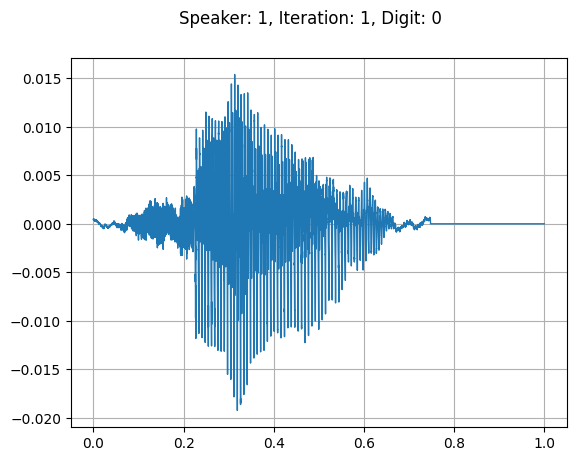

In [56]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)


# visualizing 1 clip of each number from 1 speaker
for i in range(0, 50, 50):
    plot_waveform(audio_dataset[i][0], 48000, title=f'Speaker: 1, Iteration: 1, Digit: {i//50}')

That's one example of what we can expect each digit's waveform to look. However, one of the most useful features in sound classification is its mel-spectrogram. Mel-spectrograms are often used in deep learning applications in audio transformation, and is the method I'll be using in this notebook. 

Spectrograms are a way to visualize audio data in 3 dimensions: the x coordinate is your time scale, the y coordinate is your frequency (or frequency bin) and your z coordinate (or the color of a point) represents the strength of the presence of a frequency at time x.

Since the way hertz are interpreted is nonlinear (as humans perceive lower frequencies better than higher frequencies), the mel transform was devised to make it so that an increase of m Hz would make the sound to be perceived as n times louder, no matter if the difference is between 100 and 100+n Hz or 1000 and 1000+n Hz. 

In [57]:
# define a spectrogram transform
mel_spectrogram = audioTFs.MelSpectrogram(
    sample_rate=48000,
    n_mels=64,
    n_fft=1024
)

Let's plot some of our spectrograms. The function below allows us to plot data passed to our transform defined above. Feel free to toy with minIter, maxIter, and step to plot whichever files you wish. For example, to plot the first iteration each speaker says the digit 0, minIter remains at 0, maxIter goes to 30000, and step gets set to 500.

If you plot a large amount of graphs and scroll through them really quickly, you can see how each digit's spectrograms roughly resemble each other and how they differentiate from other digits, despite factors such as the accents of each speaker.

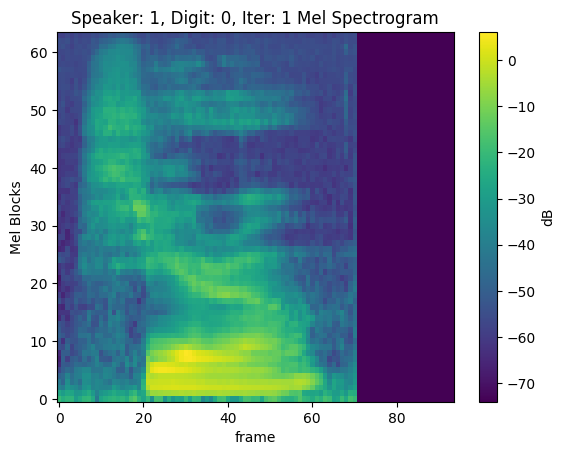

In [58]:
from librosa import power_to_db

def plot_spectrogram(spectrogram, filenum):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(f'Speaker: {filenum//500+1}, Digit: {(filenum//50)%10}, Iter: {filenum%50+1} Mel Spectrogram')
    axs.set_ylabel('Mel Blocks')
    axs.set_xlabel('frame')
    im = axs.imshow(power_to_db(spectrogram), origin='lower', aspect='auto')
    fig.colorbar(im, ax=axs).set_label('dB')
    plt.show(block=False)

# every 50 files: new digit, iterations reset
# every 500 files: new speaker, digits & iterations reset
# total speakers: 60, total files: 30000
minIter = 0
maxIter = 50
step = 50

for i in range(minIter, maxIter, step):
    aud_tensor = audio_dataset[i][0][0]
    spec = mel_spectrogram(aud_tensor)
    plot_spectrogram(spectrogram=spec, filenum=i)

In [59]:
# Let's just confirm all our spectrogram tensors are the same size so our model doesn't have a stroke...

# size = mel_spectrogram(data[0][0][0]).size()
# print(size)

# for i in range(30000):
#     assert mel_spectrogram(data[i][0][0]).size() == size

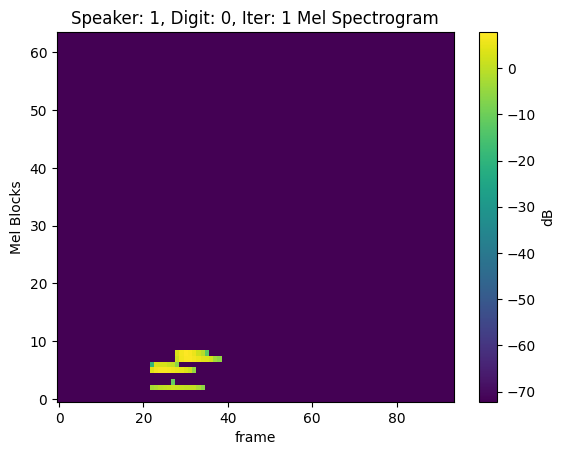

In [60]:
"""
Now that we know our mel-spectrogram-transformed data is ready to go, let's apply that
transformation the same way we applied our 0-padding transformation: redefining that method.
"""

def getSpectrogramData(self, index):
    audio_file_path = self.getAudioPath(index=index)
    label = str(self.annotations.loc[index, 'classification'])
    waveform, _ = torchaudio.load(audio_file_path)

    waveform = padAudio(waveform, cutoff=48000)
    # remembering that our mel spectrogram transform worked with flattened data, [[data]][0] == [data]
    spec_tensor = mel_spectrogram(waveform[0])

    return power_to_db(spec_tensor), label

# copied from padded audio cell to allow rerunnability without having to run that cell again
AudioMNISTDataset.__getitem__ = getPaddedAudio
audio_dataset = AudioMNISTDataset(annotations_file=annotations_file_path, audio_dir=audio_dir_path)

# apply transform to dataset
AudioMNISTDataset.__getitem__ = getSpectrogramData
audio_dataset = AudioMNISTDataset(annotations_file=annotations_file_path, audio_dir=audio_dir_path)

# test if spectrogram works by plotting
tensor, label = audio_dataset[0]
plot_spectrogram(tensor, 0)

In [61]:
def Normalize01Tensor(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())

def getNormalizedSpec(self, index):
    audio_file_path = self.getAudioPath(index=index)
    label = str(self.annotations.loc[index, 'classification'])
    waveform, _ = torchaudio.load(audio_file_path)

    waveform = padAudio(waveform, cutoff=48000)
    # remembering that our mel spectrogram transform worked with flattened data, [[data]][0] == [data]
    spec_tensor = mel_spectrogram(waveform[0])
    spec_tensor = torch.Tensor(power_to_db(spec_tensor)).unsqueeze(dim=0)

    return Normalize01Tensor(spec_tensor), label
# copied from padded audio cell to allow rerunnability without having to run that cell again
AudioMNISTDataset.__getitem__ = getPaddedAudio
audio_dataset = AudioMNISTDataset(annotations_file=annotations_file_path, audio_dir=audio_dir_path)

# apply transform to dataset
AudioMNISTDataset.__getitem__ = getNormalizedSpec
audio_dataset = AudioMNISTDataset(annotations_file=annotations_file_path, audio_dir=audio_dir_path)

With our fully-transformed dataset ready, let's split our data into train and test batches and pass them to a dataloader.

In [62]:
train_data, test_data = random_split(dataset=audio_dataset, lengths=(24000, 6000))
train_loader = DataLoader(train_data, batch_size=128, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, drop_last=True)

In [63]:
tdata, tlabel = next(iter(train_loader))
tdata.size()

torch.Size([128, 1, 64, 94])

In [64]:
# dims: 64*94
# post 1st conv2d: 60*90
# post 1st maxpool2d: 20*30
# post 2nd conv2d: 16*26
# post 2nd maxpool2d: 8*13
# post 3rd conv2d: 4*9
beta = 0.55

spike_grad = surrogate.fast_sigmoid(slope=20)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model = nn.Sequential(
    nn.Conv2d(1, 12, 5),
    nn.MaxPool2d(3),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Conv2d(12, 32, 5),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Conv2d(32, 64, 5),
    nn.Flatten(),
    nn.Linear(64*4*9, 10),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
).to(device=device)
print(device)

cuda


In [65]:
# torch.set_printoptions(threshold=30000)

# sample = audio_dataset[0][0]

# for row in sample:
#     print(row)

In [66]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = torch.Tensor([int(num) for num in targets]).type(torch.long)
targets = targets.to(device)

In [67]:
def forward_pass(net, num_steps, data):
    mem_rec = []
    spk_rec = []
    utils.reset(net)  # resets hidden states for all LIF neurons in net

    for step in range(num_steps):
        spk_out, mem_out = net(data)
        spk_rec.append(spk_out)
        mem_rec.append(mem_out)

    return torch.stack(spk_rec), torch.stack(mem_rec)

spk_rec, mem_rec = forward_pass(net=model, num_steps=100, data=data)

In [68]:
loss_fn = SF.ce_rate_loss()
loss_val = loss_fn(spk_rec, targets)
print(f"The loss from an untrained network is {loss_val.item():.3f}")
acc = SF.accuracy_rate(spk_rec, targets)
print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

The loss from an untrained network is 2.303
The accuracy of a single batch using an untrained network is 8.594%


In [69]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = torch.Tensor([int(label) for label in targets])
      targets = targets.to(device).type(torch.long)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [70]:
from time import perf_counter

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 1
loss_hist = []
test_acc_hist = []
counter = 0

start_time = exec_time = perf_counter()

# Outer training loop
print("beta:", beta, "cuda:", torch.cuda.is_available())
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = torch.Tensor([int(label) for label in targets])
        targets = targets.to(device).type(torch.long)

        # forward pass
        model.to(device=device).train()
        spk_rec, _ = forward_pass(model, 100, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 50 == 0:
            with torch.no_grad():
                model.eval()

                # Test set forward pass
                test_acc = batch_accuracy(test_loader, model, 100)
                cur_time = perf_counter()
                print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%, Batch Time: {round(cur_time - exec_time, 3)}s, Total Time: {round(cur_time - start_time, 3)}s\n")
                exec_time = cur_time
                test_acc_hist.append(test_acc.item())

        counter += 1

beta: 0.55 cuda: True
Iteration 0, Test Acc: 9.19%, Batch Time: 74.809s, Total Time: 74.809s

Iteration 50, Test Acc: 68.75%, Batch Time: 171.538s, Total Time: 246.347s

Iteration 100, Test Acc: 78.89%, Batch Time: 153.451s, Total Time: 399.798s

Iteration 150, Test Acc: 84.21%, Batch Time: 169.92s, Total Time: 569.719s



*drops fast sigmoid slope from 25 to 20*

`beta: 0.55 cuda: True`

`Iteration 0, Test Acc: 10.02%, Batch Time: 56.833s, Total Time: 56.833`

`Iteration 50, Test Acc: 10.43%, Batch Time: 356.008s, Total Time: 412.841`

Note to self: do NOT fuck with fast sigmoid slope